<a href="https://colab.research.google.com/github/ye-seul2/cnu_sw_academy/blob/main/_%EC%8B%A4%EC%A0%84_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8__CNN%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%ED%92%8D%EA%B2%BD_Scene__%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98__%EB%AC%B8%EC%A0%9C%EC%A7%80_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>실전 프로젝트 - CNN을 활용한 풍경(Scene) 이미지 분류</b>

* 한 장의 풍경 이미지가 주어졌을 때, 어떠한 카테고리(category)에 속하는지 맞히는 <b>분류 모델</b>을 만드세요.
* 다음의 세 가지 대표적인 CNN 모델을 실습합니다.
    1. [LeNet (1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
    2. [AlexNet (2012 NIPS)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
    3. [ResNet (2016 CVPR)](https://arxiv.org/abs/1512.03385)
* 성능을 올릴 수 있는 두 가지 심화 기법을 실습합니다.
    1. [Mixup (ICLR 2018)](https://arxiv.org/abs/1710.09412): 데이터 증진 기법의 일종으로 정확도를 높입니다.
    2. Transfer Learning: 학습 속도와 정확도를 모두 향상시킬 수 있습니다.
* 본 프로젝트는 <b>총 7개의 문제</b>로 구성됩니다.
    * <b>Problem</b>이라고 명시된 부분의 소스코드만 작성합니다.
    * <b>알아보기</b>라고 명시된 부분은 단순히 읽고 실행하면 됩니다.
    * 단계적으로 문제를 풀어나가는 과정에서 CNN 기반의 고성능 분류 모델을 학습하는 방법을 이해할 수 있습니다.
* (참고) 본 실습 코드에서는 빠른 결과 도출을 위해 30~50 epoch 정도만 학습합니다.
    * 풍경 데이터셋에 대하여 완전히 학습시키기 위해서는 100 epoch 이상의 학습이 필요합니다.

#### <b>(알아보기) 지난 프로젝트 Review</b>

* 지난 프로젝트에서는 Scene Classification 데이터셋에 대하여 간단한 기계학습 모델을 학습했습니다.
    1. 선형 분류 모델(Linear Models for Classification)
    2. KNN (K-Nearest Neighbors)
* 하지만, 두 기법 모두 정확도(accuracy)가 <b>60% 미만</b>으로 낮게 나온다는 <b>한계점</b>이 존재했습니다.
* 본 실습에서는 CNN을 이용해 정확도를 <b>최소한 90% 이상으로</b> 높입니다.
    * 실제로 현업에서 많이 사용되는 테크닉을 이용해 최대한 정확도를 끌어올려 봅시다.

#### <b>Problem 1. 데이터셋 다운로드 및 분석하기</b>

* [PyTorch용 Scene Classification 데이터셋 저장소](https://github.com/ndb796/Scene-Classification-Dataset-Split)
    * 참고: [원본 Kaggle 데이터셋 링크](https://www.kaggle.com/nitishabharathi/scene-classification)
    * 본 데이터셋은 <b>저작권이 없는(No Copyright)</b> [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/) 라이센스를 따라므로, 자유롭게 변형할 수 있습니다.
* PyTorch에서 곧바로 불러와 사용할 수 있도록 구성된 데이터셋입니다.
* 다음의 명령어를 이용해 데이터셋을 다운로드할 수 있습니다.

<pre>
# 깃허브에서 데이터셋 다운로드하기
!git clone https://github.com/ndb796/Scene-Classification-Dataset-Split 
# 폴더 안으로 이동
%cd Scene-Classification-Dataset-Split 
</pre>

In [1]:
# 깃허브에서 데이터셋 다운로드하기
!git clone https://github.com/ndb796/Scene-Classification-Dataset-Split 
# 폴더 안으로 이동
%cd Scene-Classification-Dataset-Split

Cloning into 'Scene-Classification-Dataset-Split'...
remote: Enumerating objects: 17038, done.
remote: Total 17038 (delta 0), reused 0 (delta 0), pack-reused 17038
Receiving objects: 100% (17038/17038), 136.02 MiB | 49.90 MiB/s, done.
/content/Scene-Classification-Dataset-Split


In [ ]:
import os
import torch
from torchvision import datasets, transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import pandas as pd
import seaborn as sns



#### <b>(알아보기) 데이터셋 설명</b>

* 본 PyTorch용 장면(scene) 데이터셋은 17,034개의 다양한 <b>자연 경치(scene)</b> 이미지로 구성되어 있습니다.
* 총 6개의 클래스(class)로 구성됩니다.

<pre>
클래스 0. 빌딩(buildings)
클래스 1. 숲(forests)
클래스 2. 빙하(glacier)
클래스 3. 산(mountains)
클래스 4. 바다(sea)
클래스 5. 거리(street)
</pre>

* 각 이미지는 공통적으로 64 X 64 크기를 가집니다.
* 데이터셋 폴더 구성은 다음과 같습니다.

<pre>
Dataset/
    train/
        buildings/
        forests/
        glacier/
        mountains/
        sea/
        streat/
    val/
        buildings/
        forests/
        glacier/
        mountains/
        sea/
        streat/
</pre>

#### <b>(알아보기) 클래스별 학습 이미지 개수 출력하기</b>

* 클래스별 데이터의 개수를 계산합니다.
    * os 라이브러리의 os.listdir()를 이용하여 이미지 폴더에 존재하는 파일 이름 목록을 얻을 수 있습니다.
    * 클래스의 개수는 6개입니다.
* 총 학습 데이터의 개수는 13,627개입니다.

<pre>
클래스 0. 빌딩(buildings): 2,105개
클래스 1. 숲(forests): 2,205개
클래스 2. 빙하(glacier): 2,363개
클래스 3. 산(mountains): 2,438개
클래스 4. 바다(sea): 2,224개
클래스 5. 거리(street): 2,292개
</pre>

* 총 검증 데이터의 개수는 3,407개입니다.

<pre>
클래스 0. 빌딩(buildings): 523개
클래스 1. 숲(forests): 540개
클래스 2. 빙하(glacier): 594개
클래스 3. 산(mountains): 599개
클래스 4. 바다(sea): 560개
클래스 5. 거리(street): 591개
</pre>

In [2]:
import os


classes = ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']
train_path = 'train/'
val_path = 'val/'

print("[ 학습 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(train_path + classes[i]))}')

print("[ 검증 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(val_path + classes[i]))}')

[ 학습 데이터셋 ]
클래스 0의 개수: 2105
클래스 1의 개수: 2205
클래스 2의 개수: 2363
클래스 3의 개수: 2438
클래스 4의 개수: 2224
클래스 5의 개수: 2292
[ 검증 데이터셋 ]
클래스 0의 개수: 523
클래스 1의 개수: 540
클래스 2의 개수: 594
클래스 3의 개수: 599
클래스 4의 개수: 560
클래스 5의 개수: 591


In [ ]:
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 2.4/2.4 GB ? eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 32.9 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 38.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


#### <b>(알아보기) 데이터셋 불러오기</b>

* PyTorch의 <b>ImageFolder 라이브러리</b>를 이용하여 <b>자신만의 데이터셋</b>을 불러올 수 있습니다.
* ImageFolder 라이브러리는 다음과 같이 <b>계층적인 폴더 구조</b>에서 데이터셋을 불러올 때 사용할 수 있습니다.
    * 각 클래스명(class name)으로 된 폴더에 여러 장의 이미지가 들어가 있는 구조입니다.

<pre>
dataset/
    class 0/
        0.jpg
        1.jpg
        ...
    class 1/
        0.jpg
        1.jpg
        ...
    ...
    class 9/
        0.jpg
        1.jpg
        ...
</pre>

* 기본적인 <b>데이터 증진(data augmentation)</b> 기법을 사용합니다.
    * [RandomResizedCrop()](https://pytorch.org/vision/stable/transforms.html): 학습 시기에 랜덤으로 이미지의 일부를 잘라내어 특정 크기로 변형합니다.
    * [RandomHorizontalFlip()](https://pytorch.org/vision/stable/transforms.html): 학습 시기에 랜덤으로 이미지를 좌우 반전합니다.
* <b>정규화(normalization)를</b> 진행합니다.
    * 일반적으로 많이 사용되는 ImageNet 데이터셋의 설정을 이용합니다.

In [3]:
import torch
from torchvision import datasets, transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transforms_train)
val_dataset = datasets.ImageFolder(val_path, transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


#### <b>(알아보기) 이미지 시각화하기</b>

* PyTorch로 불러온 데이터(torch.Tensor 객체)를 시각화해 봅시다.
* Google Colab에 출력하기 위해서 NumPy 형태로 변형한 뒤에 Matplotlib을 이용합니다.
    * torch.Tensor는 (Channel, Height, Width) 형식을 가집니다.
    * numpy 객체는 (Height, Width, Channel) 형식을 가집니다.

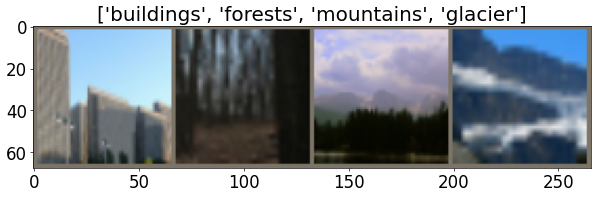

In [4]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 이미지 정규화(normalization) 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 학습 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(train_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

#### <b>Problem 2. Convolution 연산 이해하기</b>

* Convolution 연산의 동작 원리를 이해할 필요가 있습니다.
* <b>[그림 예시]</b> 아래 그림에서는 stride가 1이고, padding이 0일 때의 Convolution 연산 예시를 보입니다.

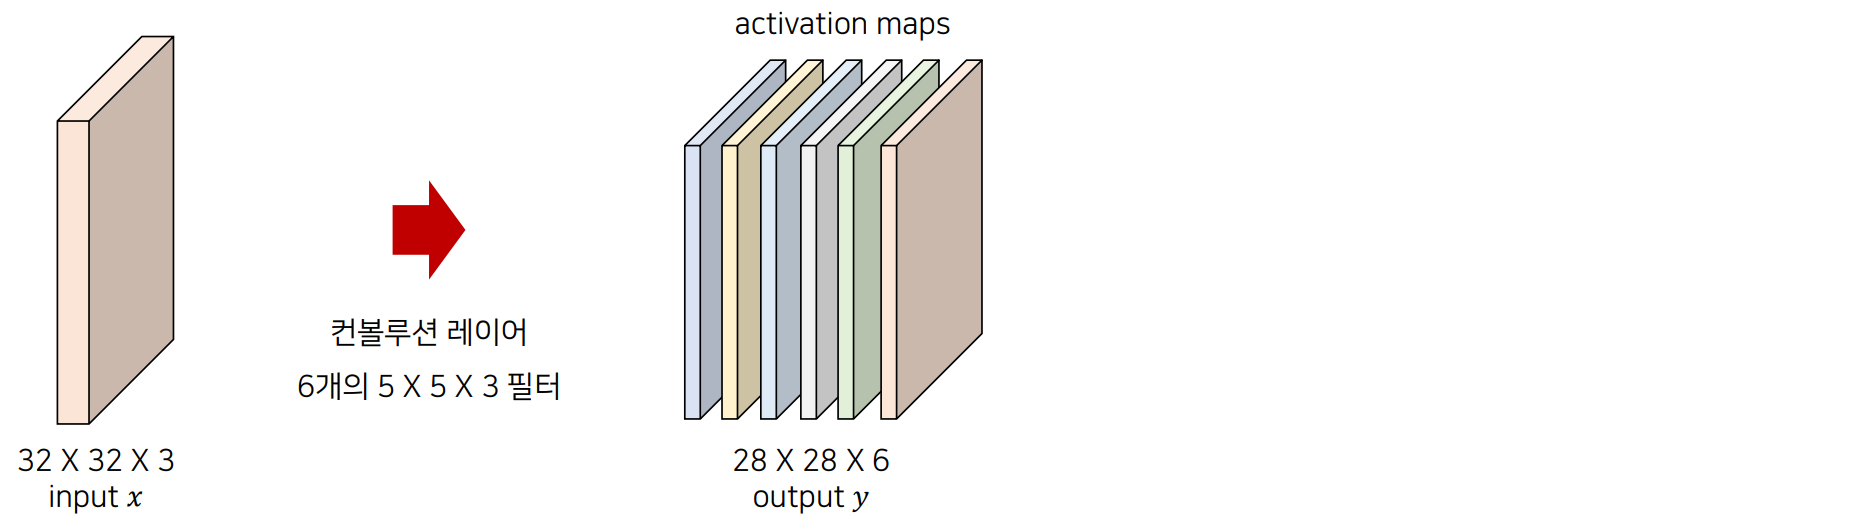

<hr>

* 입력 데이터의 높이: $height$
* 입력 데이터의 너비: $width$
* 필터의 높이: $filter\_height$
* 필터의 너비: $filter\_width$
* 스트라이드(stride): $stride$
* 패딩 크기: $padding$

<hr>

* Convolution 연산 이후의 출력 차원은 다음과 같은 공식으로 계산할 수 있습니다. (나누기할 때 소수점 아래 버림)
    * 출력 높이(output height) = $(height + 2 * padding - filter\\_height) / stride + 1$
    * 출력 너비(output width) = $(width + 2 * padding - filter\\_width) / stride + 1$

* <b>[문제]</b> 다음의 각 경우에 대하여 Convolution 연산을 수행한 뒤의 출력 차원을 쓰세요.
    1. $height=32$, $width=32$, $filter\\_height=5$, $filter\\_width=5$, $stride=2$, $padding=2$일 때 → { 16 X 16 }
    2. $height=64$, $width=64$, $filter\\_height=3$, $filter\\_width=3$, $stride=1$, $padding=1$일 때 → { 64 X 64 }
    3. $height=16$, $width=16$, $filter\\_height=4$, $filter\\_width=4$, $stride=2$, $padding=1$일 때 → { 8 X 8 }
    4. $height=60$, $width=45$, $filter\\_height=8$, $filter\\_width=5$, $stride=3$, $padding=1$일 때 → { 19 X 15 }

* (Hint) 다음과 같은 Python 코드를 사용하여 간단히 계산할 수 있습니다.

<pre>
height = 16
width = 16
filter_height = 4
filter_width = 4
stride = 2
padding = 1

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)
</pre>

* 실행 결과 예시

<pre>
출력 높이: 8 출력 너비: 8
</pre>

In [5]:
height = 7
width = 7
filter_height = 2
filter_width = 2
stride = 2
padding = 0

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)

출력 높이: 3 출력 너비: 3


#### <b>(알아보기) Lenet 아키텍처 이해하기</b>

* 기본적인 LeNet 아키텍처를 이해할 수 있습니다.
    * Convolutional Neural Network를 최초로(1998년) 적용한 간단한 아키텍처입니다.
    * Convolution 연산과 Pooling 연산이 사용됩니다.
* <b>아래의 표</b>와 같은 아키텍처를 PyTorch로 구현한 것을 확인해 봅시다.
    * 원본 논문과 완전히 동일하지는 않지만, 핵심 아이디어를 잘 표현한 아키텍처입니다.
    * PyTorch에서는 모델에 별도로 Softmax 레이어를 두지 않고, 학습할 때 nn.CrossEntropyLoss()를 사용하는 것이 일반적입니다.

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 20, kernel size: 5 X 5, stride: 1, zero padding: 0
3 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
4 | Convolution | # of kernel: 50, kernel size: 5 X 5, stride: 1, zero padding: 0
5 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
6 | Fully Connected | # of neuron: 500
7 | Activation | ReLU
8 | Fully Connected | # of neuron: 6
9 | Softmax | 6 classes



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (20 x 60 x 60)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (20 x 30 x 30)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (50 x 26 x 26)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (50 x 13 x 13)
        self.fc1 = nn.Linear(50 * 13 * 13, 500)
        # → 차원(dimension): (500)
        self.fc2 = nn.Linear(500, 6)
        # → 차원(dimension): (6)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = torch.flatten(x, 1) # 배치(batch)를 제외한 모든 차원 flatten하기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### <b>(알아보기) 학습 및 평가 함수 이해하기</b>

* 별도의 학습(train) 함수와 평가(validate) 함수를 작성합니다.

In [7]:
def train(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = criterion(outputs, targets) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def validate(net, epoch, val_dataloader):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs) # 모델 입력하여 결과 계산
        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', val_loss / total)
    return (100. * correct / total, val_loss / total)

#### <b>(알아보기) LeNet 학습하기</b>

* 앞서 정의한 LeNet 네트워크를 학습합니다.
* 학습률(learning rate)을 수정해보면서 결과를 확인해 봅시다.
    * 만약 학습률이 너무 크다면, 발산하여 손실(loss) 값이 NaN으로 나오며 학습이 안 될 수 있습니다.

In [8]:
import time
import torch.optim as optim


net = LeNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LeNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 51.03837968738534
Train average loss: 0.039698767746904146
[ Validation epoch: 1 ]
Accuarcy: 66.45142353977106
Average loss: 0.0299771955925102
Model saved! (time elapsed: 19.315935134887695)
[ Train epoch: 1 ]
Train accuarcy: 58.37675203639833
Train average loss: 0.03378646128979137
[ Validation epoch: 2 ]
Accuarcy: 69.91488112709128
Average loss: 0.02804266612201553
Model saved! (time elapsed: 31.670830011367798)
[ Train epoch: 2 ]
Train accuarcy: 61.5249137741249
Train average loss: 0.031519397715965146
[ Validation epoch: 3 ]
Accuarcy: 66.4220722042853
Average loss: 0.027597324315284683
Model saved! (time elapsed: 45.527427434921265)
[ Train epoch: 3 ]
Train accuarcy: 63.359506861378144
Train average loss: 0.03052246290213068
[ Validation epoch: 4 ]
Accuarcy: 72.58585265629586
Average loss: 0.02455568642500107
Model saved! (time elapsed: 58.02460479736328)
[ Train epoch: 4 ]
Train accuarcy: 64.50429294782417
Train average loss: 0.02931321208331978

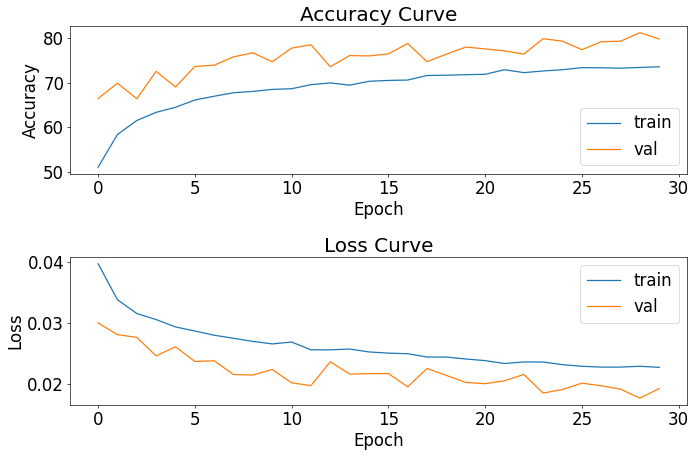

In [9]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

#### <b>(알아보기) 혼동 행렬 시각화하기</b>

* 참고: [Seaborn.heatmap 공식 문서](https://seaborn.pydata.org/generated/seaborn.heatmap.html) 
* 각 클래스에 대하여 정확히 분류하는지 확인하기 위해 <b>혼동 행렬(confusion matrix)</b>을 생성할 수 있습니다.

In [10]:
# 네트워크에 데이터셋을 입력하여 혼동 행렬(confusion matrix)을 계산하는 함수
def get_confusion_matrix(net, num_classes, data_loader):
    net.eval() # 모델을 평가 모드로 설정
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


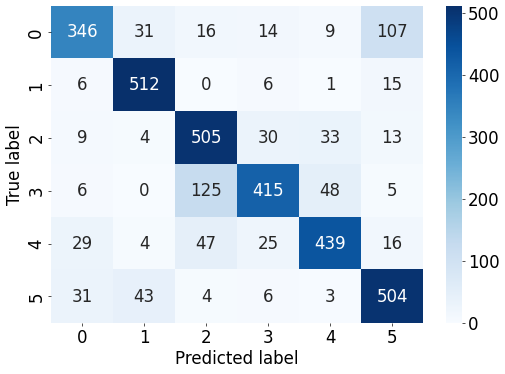

[ 각 클래스에 따른 정확도 ]
tensor([0.6616, 0.9481, 0.8502, 0.6928, 0.7839, 0.8528])
[ 전체 평균 정확도 ]
tensor(0.7986)


In [11]:
import pandas as pd
import seaborn as sns


net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 3. CustomLeNet 아키텍처 작성하기</b>

* 다음과 같이 LeNet 아키텍처를 변경하여 CustomLeNet을 만들어 봅시다.
    * 커널 크기와 커널의 개수를 증가시켰습니다. (파라미터 수 증가)
    * Fully Connected 레이어의 차원을 증가시켰습니다. (파라미터 수 증가)

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 128, kernel size: 8 X 8, stride: 1, zero padding: 0
3 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
4 | Convolution | # of kernel: 256, kernel size: 8 X 8, stride: 1, zero padding: 0
5 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
6 | Convolution | # of kernel: 512, kernel size: 4 X 4, stride: 1, zero padding: 0
7 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
8 | Fully Connected | # of neuron: 4096
9 | Activation | ReLU
10 | Fully Connected | # of neuron: 6
11 | Softmax | 6 classes


In [12]:
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        # 이 부분에 소스코드를 작성하세요.
        
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=8, stride=1, padding=0)
        # → 차원(dimension): (128 x 57 x 57)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (128 x 28 x 28)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=8, stride=1, padding=0)
        # → 차원(dimension): (256 x 21 x 21)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (256 x 10 x 10)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0)
        # → 차원(dimension): (512 x 7 x 7)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (512 x 3 x 3)
        self.fc1 = nn.Linear(512 * 3 * 3, 4096)
        # → 차원(dimension): (500)
        self.fc2 = nn.Linear(4096, 6)
        # → 차원(dimension): (6)

    def forward(self, x):
        # 이 부분에 소스코드를 작성하세요.
        
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = torch.flatten(x, 1) # 배치(batch)를 제외한 모든 차원 flatten하기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### <b>(알아보기) CustomLeNet 평가하기</b>

* 새롭게 작성한 CustomLeNet과 앞선 LeNet의 성능을 비교합니다.
    * 파라미터가 증가한 만큼 성능 향상이 있는지 확인해 봅시다.
* 아래 코드를 실행하여 학습 및 성능 평가를 진행할 수 있습니다.

In [13]:
import time
import torch.optim as optim


net = CustomLeNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "CustomLeNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 48.22044470536435
Train average loss: 0.040928619207285764
[ Validation epoch: 1 ]
Accuarcy: 62.19547989433519
Average loss: 0.03140144857941816
Model saved! (time elapsed: 37.52587294578552)
[ Train epoch: 1 ]
Train accuarcy: 55.85969032068687
Train average loss: 0.035342389448833125
[ Validation epoch: 2 ]
Accuarcy: 64.66099207513942
Average loss: 0.028967166860186883
Model saved! (time elapsed: 73.49017643928528)
[ Train epoch: 2 ]
Train accuarcy: 58.861084611433185
Train average loss: 0.03319124105330599
[ Validation epoch: 3 ]
Accuarcy: 67.09715292045789
Average loss: 0.028340543806990255
Model saved! (time elapsed: 110.22624182701111)
[ Train epoch: 3 ]
Train accuarcy: 60.42415792177295
Train average loss: 0.03225533581885779
[ Validation epoch: 4 ]
Accuarcy: 68.62342236571764
Average loss: 0.0273627092455502
Model saved! (time elapsed: 146.76505827903748)
[ Train epoch: 4 ]
Train accuarcy: 61.63498935936009
Train average loss: 0.031445454840808

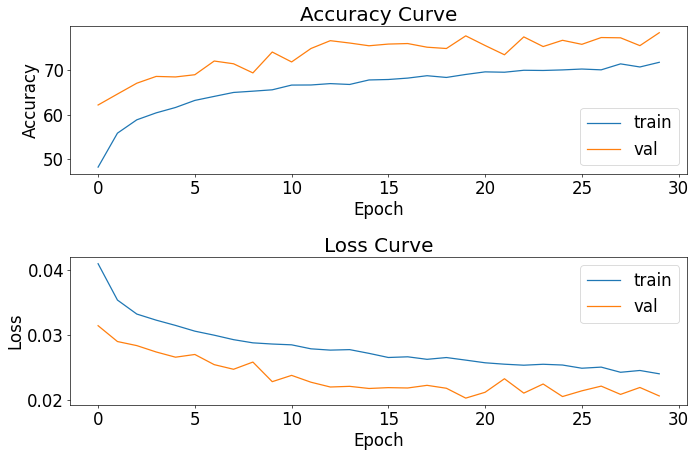

In [14]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


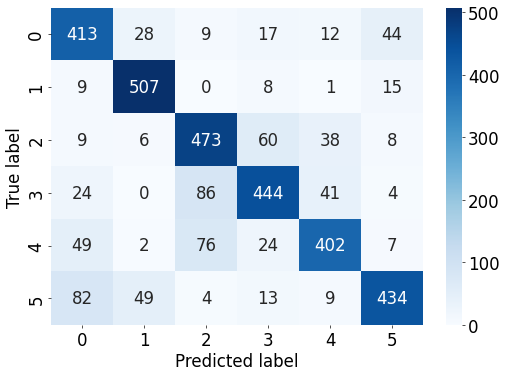

[ 각 클래스에 따른 정확도 ]
tensor([0.7897, 0.9389, 0.7963, 0.7412, 0.7179, 0.7343])
[ 전체 평균 정확도 ]
tensor(0.7846)


In [15]:
import pandas as pd
import seaborn as sns


net = CustomLeNet()
net = net.to(device)

file_name = "./checkpoint/CustomLeNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 4. AlexNet 아키텍처 작성하기</b>

* AlexNet은 CNN 기반의 분류 모델의 우수성을 전 세계에 알린 논문([NIPS 2012](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf))입니다.
    * ImageNet 분류 대회(ILSVRC 2012)에서 압도적인 성능으로 우승(1위)을 차지했습니다.

<hr>

* LRN (Local Response Normalization)을 활용합니다.
    * PyTorch에서 [nn.LocalResponseNorm()](https://pytorch.org/docs/stable/generated/torch.nn.LocalResponseNorm.html)을 이용해 구현할 수 있습니다.
    * Local Response Normalization은 입력과 출력의 차원이 동일한 레이어입니다.
* Dropout을 활용합니다.
    * PyTorch에서 [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)을 이용해 구현할 수 있습니다.
* ReLU를 적극적으로 활용합니다.
    * PyTorch에서 [nn.ReLU()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)를 이용해 구현할 수 있습니다.

<hr>

* <b>아래의 표</b>와 같은 아키텍처를 PyTorch로 구현해 봅시다.
    * 원본 논문에서 제안한 것과 완전히 동일한 아키텍처는 아니지만, 핵심 아이디어를 잘 포함하고 있습니다.

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 96, kernel size: 5 X 5, stride: 1, zero padding: 2
3 | Activation | ReLU
4 | Normalization | LRN (Local Response Normalization), size: 5
5 | Pooling | max pooling, kernel size: 3 X 3, stride: 2
6 | Convolution | # of kernel: 256, kernel size: 5 X 5, stride: 1, zero padding: 2
7 | Activation | ReLU
8 | Normalization | LRN (Local Response Normalization), size: 5
9 | Pooling | max pooling, kernel size: 3 X 3, stride: 2
10 | Convolution | # of kernel: 384, kernel size: 3 X 3, stride: 1, zero padding: 1
11 | Activation | ReLU
12 | Convolution | # of kernel: 384, kernel size: 3 X 3, stride: 1, zero padding: 1
13 | Activation | ReLU
14 | Convolution | # of kernel: 256, kernel size: 3 X 3, stride: 1, zero padding: 1
15 | Activation | ReLU
16 | Pooling | max pooling, kernel size: 3 X 3, stride: 2
17 | Fully Connected | # of neuron: 4096
18 | Activation | ReLU
19 | Dropout | Probability: 0.5
20 | Fully Connected | # of neuron: 6
21 | Dropout | Probability: 0.5
22 | Softmax | 6 classes

* 표와 동일하게 정상적으로 구현했다면, <b>83~85%가량의 정확도</b>를 얻을 수 있습니다.

In [16]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 이 부분에 소스코드를 작성하세요.
        self.features = nn.Sequential(
            # → 차원(dimension): (3 x 64 x 64)
            # 입력 채널: 3, 출력 채널: 96 (커널 96개)
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5),
            # 여기에서 (96 x 64 x 64)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (96 x 31 x 31)
            # 입력 채널: 96, 출력 채널: 256 (커널 256개)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5),
            # 여기에서 (256 x 31 x 31)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (256 x 15 x 15)
            # 입력 채널: 256, 출력 채널: 384 (커널 384개)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 15 x 15)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 15 x 15)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 256 (커널 384개)
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            # 여기에서 (256 x 15 x 15)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (256 x 7 x 7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 6),
            nn.Dropout(),
        )
        
        
        

    def forward(self, x):
        # 이 부분에 소스코드를 작성하세요.
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### <b>(알아보기) AlexNet 평가하기</b>

* 아래 코드를 실행하여 학습 및 성능 평가를 진행할 수 있습니다.
* 83~85%가량의 정확도가 나오지 않는다면, 표와 동일하게 AlexNet 코드를 다시 작성했는지 확인해 주세요.

In [17]:
import time
import torch.optim as optim


net = AlexNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "AlexNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 30.109341748000293
Train average loss: 0.05101693827783824
[ Validation epoch: 1 ]
Accuarcy: 54.91634869386557
Average loss: 0.037405616365152265
Model saved! (time elapsed: 40.27064776420593)
[ Train epoch: 1 ]
Train accuarcy: 38.827328098627724
Train average loss: 0.04555905717322191
[ Validation epoch: 2 ]
Accuarcy: 61.520399178162606
Average loss: 0.03375324794964109
Model saved! (time elapsed: 80.38563323020935)
[ Train epoch: 2 ]
Train accuarcy: 41.483818888970426
Train average loss: 0.04385900701265425
[ Validation epoch: 3 ]
Accuarcy: 65.89374816554154
Average loss: 0.030721544152241074
Model saved! (time elapsed: 120.5515718460083)
[ Train epoch: 3 ]
Train accuarcy: 43.28905848682762
Train average loss: 0.04227424591261389
[ Validation epoch: 4 ]
Accuarcy: 67.18520692691517
Average loss: 0.03058602644055688
Model saved! (time elapsed: 160.71479392051697)
[ Train epoch: 4 ]
Train accuarcy: 43.93483525354076
Train average loss: 0.04161737980737

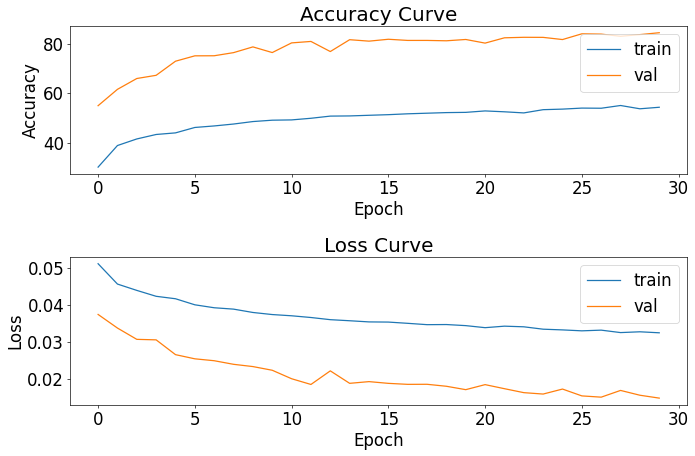

In [18]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


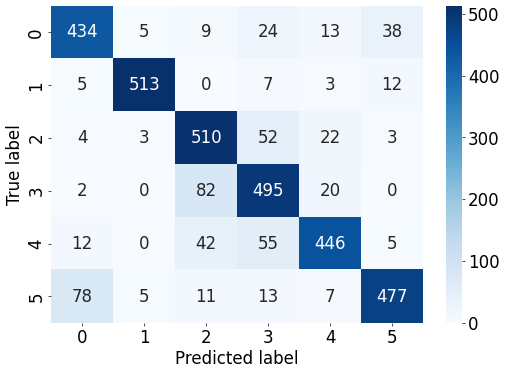

[ 각 클래스에 따른 정확도 ]
tensor([0.8298, 0.9500, 0.8586, 0.8264, 0.7964, 0.8071])
[ 전체 평균 정확도 ]
tensor(0.8439)


In [19]:
import pandas as pd
import seaborn as sns


net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>(알아보기) LightResNet 아키텍처 살펴보기</b>

* [ResNet (2016 CVPR)](https://arxiv.org/abs/1512.03385) 논문에서 제안된 가벼운 ResNet을 PyTorch로 구현한 것은 다음과 같습니다.
    * 원본 논문에서는 CIFAR-10을 위하여 해당 아키텍처를 제안했습니다.
* 레이어의 깊이에 따라 다양한 버전이 있습니다.
    * 다양한 버전: 20 레이어, 32 레이어, 44 레이어, 56 레이어, 110 레이어
    * 일반적으로 더 깊은 레이어로 구성된 ResNet이 더 높은 정확도를 보입니다.

In [20]:
# ResNet을 위한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (stride 값이 2라면, 너비와 높이가 절반으로 감소)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (stride 값이 1이므로, 너비와 높이가 유지)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# LightResNet 클래스 정의
class LightResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(LightResNet, self).__init__()
        self.in_planes = 16

        # 16개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫째 블록만 너비와 높이 감소
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1) # 배치(batch)를 제외한 모든 차원 flatten하기
        out = self.linear(out)
        return out


def LightResNet20():
    return LightResNet(BasicBlock, [3, 3, 3])


def LightResNet32():
    return LightResNet(BasicBlock, [5, 5, 5])


def LightResNet44():
    return LightResNet(BasicBlock, [7, 7, 7])


def LightResNet56():
    return LightResNet(BasicBlock, [9, 9, 9])


def LightResNet110():
    return LightResNet(BasicBlock, [18, 18, 18])

#### <b>(알아보기) LightResNet-20 학습하기</b>

* PyTorch로 구현된 LightResNet-20 모델을 학습해 봅시다.

In [21]:
import time
import torch.optim as optim


net = LightResNet20()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LightResNet20.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 52.17582740148235
Train average loss: 0.03660675513907942
[ Validation epoch: 1 ]
Accuarcy: 60.34634575873202
Average loss: 0.028851762995679323
Model saved! (time elapsed: 18.055153131484985)
[ Train epoch: 1 ]
Train accuarcy: 63.16870918030381
Train average loss: 0.029830892183831934
[ Validation epoch: 2 ]
Accuarcy: 67.03845024948635
Average loss: 0.026501549105508466
Model saved! (time elapsed: 35.82828760147095)
[ Train epoch: 2 ]
Train accuarcy: 68.65781169736553
Train average loss: 0.02604204267121257
[ Validation epoch: 3 ]
Accuarcy: 73.70120340475492
Average loss: 0.021803697752119825
Model saved! (time elapsed: 54.04619836807251)
[ Train epoch: 3 ]
Train accuarcy: 71.11616643428488
Train average loss: 0.024126961445645696
[ Validation epoch: 4 ]
Accuarcy: 76.04931024361609
Average loss: 0.020702249661092364
Model saved! (time elapsed: 71.7408344745636)
[ Train epoch: 4 ]
Train accuarcy: 72.59117927643649
Train average loss: 0.022778402141056

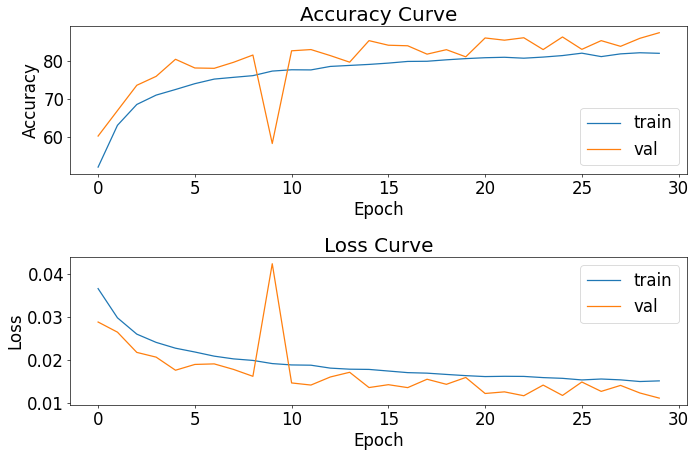

In [22]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


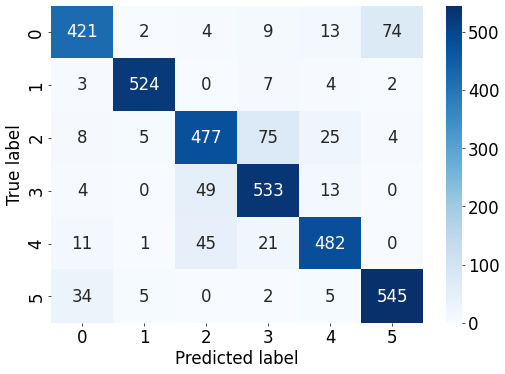

[ 각 클래스에 따른 정확도 ]
tensor([0.8050, 0.9704, 0.8030, 0.8898, 0.8607, 0.9222])
[ 전체 평균 정확도 ]
tensor(0.8753)


In [23]:
import pandas as pd
import seaborn as sns


net = LightResNet20()
net = net.to(device)

file_name = "./checkpoint/LightResNet20.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 5. 다양한 레이어 깊이에 따라 LightResNet 학습하기</b>

* Residual Block을 사용하는 경우 깊이가 깊어져도 좋은 성능을 내는 경향이 있습니다.
* 다음의 LightResNet 모델들에 대하여 각각 학습을 진행한 뒤에, 검증 정확도(validation accuracy)를 쓰세요.
    * LightResNet32: {87.61373642500733}
    * LightResNet56: {87.43762841209275}
    * LightResNet110: {86.02876430877605}
* 레이어가 깊어짐에 따라서 성능이 좋아지나요? {아니요.}
    * 그 이유는: {gradient vanishing 현상 때문입니다.}

In [24]:
import time
import torch.optim as optim


net = LightResNet32()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LightResNet32.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 50.708152931679756
Train average loss: 0.03792124864176258
[ Validation epoch: 1 ]
Accuarcy: 64.71969474611095
Average loss: 0.02960288330435858
Model saved! (time elapsed: 23.454313039779663)
[ Train epoch: 1 ]
Train accuarcy: 62.27342775372422
Train average loss: 0.030087439878466123
[ Validation epoch: 2 ]
Accuarcy: 67.06780158497212
Average loss: 0.02766629814716739
Model saved! (time elapsed: 46.97342228889465)
[ Train epoch: 2 ]
Train accuarcy: 67.74785352608791
Train average loss: 0.026403387025279695
[ Validation epoch: 3 ]
Accuarcy: 70.61931317874964
Average loss: 0.023813825086445833
Model saved! (time elapsed: 70.2104139328003)
[ Train epoch: 3 ]
Train accuarcy: 70.2282233800543
Train average loss: 0.02486759244875153
[ Validation epoch: 4 ]
Accuarcy: 71.20633988846492
Average loss: 0.025241517735465308
Model saved! (time elapsed: 93.44665241241455)
[ Train epoch: 4 ]
Train accuarcy: 72.34167461657005
Train average loss: 0.02334166805278951

In [ ]:
import time
import torch.optim as optim


net = LightResNet56()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LightResNet56.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 48.1323842371762
Train average loss: 0.03873189414003288
[ Validation epoch: 1 ]
Accuarcy: 61.6084531846199
Average loss: 0.030696814137887912
Model saved! (time elapsed: 38.66019010543823)
[ Train epoch: 1 ]
Train accuarcy: 59.778381155059805
Train average loss: 0.0316841363351361
[ Validation epoch: 2 ]
Accuarcy: 67.2439095978867
Average loss: 0.026348717932761292
Model saved! (time elapsed: 76.46029591560364)
[ Train epoch: 2 ]
Train accuarcy: 66.23614882219124
Train average loss: 0.027786712990456583
[ Validation epoch: 3 ]
Accuarcy: 70.88347519812152
Average loss: 0.02410471707906127
Model saved! (time elapsed: 114.19650864601135)
[ Train epoch: 3 ]
Train accuarcy: 69.71453731562339
Train average loss: 0.025421450497548247
[ Validation epoch: 4 ]
Accuarcy: 76.07866157910185
Average loss: 0.021268029602385
Model saved! (time elapsed: 151.97427558898926)
[ Train epoch: 4 ]
Train accuarcy: 71.43905481764145
Train average loss: 0.023907109208193424
[

In [ ]:
import time
import torch.optim as optim


net = LightResNet110()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LightResNet110.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 44.48521317971674
Train average loss: 0.04219373841274158
[ Validation epoch: 1 ]
Accuarcy: 63.95656002348107
Average loss: 0.029315540158647155
Model saved! (time elapsed: 73.43248343467712)
[ Train epoch: 1 ]
Train accuarcy: 57.202612460556246
Train average loss: 0.03367895086066882
[ Validation epoch: 2 ]
Accuarcy: 64.27942471382448
Average loss: 0.028592488284260777
Model saved! (time elapsed: 146.61217093467712)
[ Train epoch: 2 ]
Train accuarcy: 62.97057312688046
Train average loss: 0.030361467554816463
[ Validation epoch: 3 ]
Accuarcy: 72.70325799823893
Average loss: 0.023665074233894023
Model saved! (time elapsed: 219.69718146324158)
[ Train epoch: 3 ]
Train accuarcy: 66.73515814192412
Train average loss: 0.02752594490030974
[ Validation epoch: 4 ]
Accuarcy: 72.82066334018198
Average loss: 0.022980101365024198
Model saved! (time elapsed: 292.71475625038147)
[ Train epoch: 4 ]
Train accuarcy: 67.87994422837015
Train average loss: 0.026542068116

#### <b>(알아보기) ResNet 아키텍처 살펴보기</b>

* [ResNet (2016 CVPR)](https://arxiv.org/abs/1512.03385) 논문에서 제안된 기본적인 ResNet의 핵심 아이디어를 PyTorch로 구현한 것은 다음과 같습니다.
    * LightResNet에 비하여 <b>커널의 개수(number of kernels)가 많은</b> 것을 확인할 수 있습니다.
    * 따라서 ImageNet과 같은 큰 규모의 데이터셋에 대해서 사용하기에 적합합니다.
* (참고) [PyTorch 공식 ResNet 소스 코드](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [25]:
# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫째 블록만 너비와 높이 감소
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1) # 배치(batch)를 제외한 모든 차원 flatten하기
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

#### <b>(알아보기) ResNet-18 학습하기</b>

* PyTorch로 구현된 ResNet-18 모델을 학습해 봅시다.

In [26]:
import time
import torch.optim as optim


net = ResNet18()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "ResNet18.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 56.233947310486535
Train average loss: 0.034811741456147766
[ Validation epoch: 1 ]
Accuarcy: 71.94012327560904
Average loss: 0.023576765587716847
Model saved! (time elapsed: 43.095054388046265)
[ Train epoch: 1 ]
Train accuarcy: 66.79386512071622
Train average loss: 0.02728494130052561
[ Validation epoch: 2 ]
Accuarcy: 73.9653654241268
Average loss: 0.023177583458348736
Model saved! (time elapsed: 86.19946932792664)
[ Train epoch: 2 ]
Train accuarcy: 71.46106993468848
Train average loss: 0.02413856121285992
[ Validation epoch: 3 ]
Accuarcy: 76.31347226298797
Average loss: 0.020604184970570198
Model saved! (time elapsed: 129.2392430305481)
[ Train epoch: 3 ]
Train accuarcy: 74.33037352315256
Train average loss: 0.021951395876384703
[ Validation epoch: 4 ]
Accuarcy: 77.95714705019078
Average loss: 0.019274725237304176
Model saved! (time elapsed: 172.1951596736908)
[ Train epoch: 4 ]
Train accuarcy: 75.137594481544
Train average loss: 0.0209230970149258

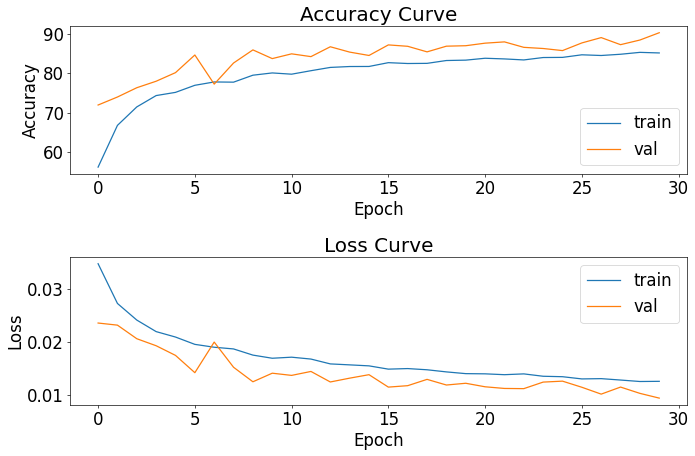

In [27]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


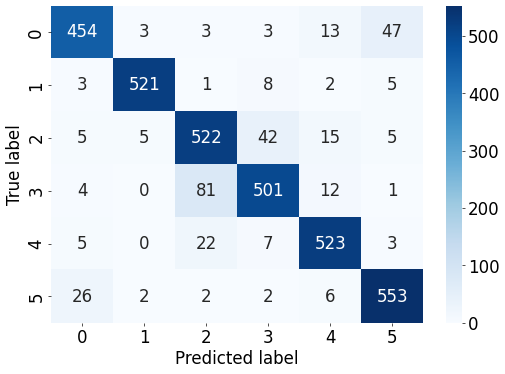

[ 각 클래스에 따른 정확도 ]
tensor([0.8681, 0.9648, 0.8788, 0.8364, 0.9339, 0.9357])
[ 전체 평균 정확도 ]
tensor(0.9023)


In [28]:
import pandas as pd
import seaborn as sns


net = ResNet18()
net = net.to(device)

file_name = "./checkpoint/ResNet18.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>(알아보기) Input Mixup 살펴보기</b>

* Mixup은 대표적인 데이터 증진(data augmentation) 기법으로 정확도 향상에 도움이 됩니다.
    * 일반적으로 Mixup을 사용하는 경우 더 많은 횟수(1.5배가량)의 epoch이 요구됩니다.

In [29]:
mixup_alpha = 1.0


def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_with_mixup(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets) # Mixup 진행
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)

In [30]:
file_name

'./checkpoint/ResNet18.pt'

#### <b>Problem 6. Mixup 결과 분석하기</b>

* Mixup을 사용하여 ResNet-18에 대하여 50번 epoch만큼 학습을 진행한 뒤에 성능이 얼마나 개선되었는지 쓰세요.
    * Mixup을 적용했을 때의 검증 정확도(validation accuracy): {89.87378925741122}

In [31]:
def validate(net, epoch, val_dataloader):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs) # 모델 입력하여 결과 계산
        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', val_loss / total)
    return (100. * correct / total, val_loss / total)

In [32]:
import time


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

start_time = time.time()

for epoch in range(0, 50):
    adjust_learning_rate(optimizer, epoch)
    train_with_mixup(net, epoch, optimizer, criterion, train_dataloader)
    validate(net, epoch, val_dataloader)
    print('\nTime elapsed:', time.time() - start_time)

[ Train epoch: 0 ]
Train accuarcy: 64.58855372915069
Train average loss: 0.047784063999254126
[ Validation epoch: 0 ]
Accuarcy: 89.78573525095392
Average loss: 0.00993879264510899

Time elapsed: 43.22929048538208
[ Train epoch: 1 ]
Train accuarcy: 64.98496544758657
Train average loss: 0.04671946696107662
[ Validation epoch: 1 ]
Accuarcy: 89.75638391546815
Average loss: 0.009982291310544514

Time elapsed: 86.66916537284851
[ Train epoch: 2 ]
Train accuarcy: 64.20665072733546
Train average loss: 0.04787465924517533
[ Validation epoch: 2 ]
Accuarcy: 89.66832990901086
Average loss: 0.00998747271480433

Time elapsed: 129.62208914756775
[ Train epoch: 3 ]
Train accuarcy: 63.396994118032794
Train average loss: 0.04778993826728841
[ Validation epoch: 3 ]
Accuarcy: 89.37481655415321
Average loss: 0.010168814881302096

Time elapsed: 172.57001376152039
[ Train epoch: 4 ]
Train accuarcy: 64.01173273142666
Train average loss: 0.04818278043497735
[ Validation epoch: 4 ]
Accuarcy: 89.60962723803934
A

#### <b>(알아보기) Transfer Learning 살펴보기</b>

* 전이 학습(Transfer Learning)은 <b>단기간에 우수한 정확도</b>를 얻기 위해 효과적으로 사용할 수 있는 기법입니다.
    * 본 실습에서는 미세 조정(fine-tuning) 기법을 사용합니다.
    * 적은 epoch만으로도 빠르게 수렴합니다.
* 전이 학습을 위해서는, 사전 학습된(pre-trained) 네트워크와 동일한 크기의 입력 차원을 갖도록 <b>데이터셋을 수정</b>해야 합니다.
    * ResNet 특성상 데이터셋 수정 없이도 동작할 수 있지만, 일반적으로 데이터셋을 수정합니다.
* (참고) [PyTorch 공식 Transfer Learning 튜토리얼](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* 기본적인 Transfer Learning을 이용해 91~93%의 정확도를 얻을 수 있습니다.

In [33]:
transforms_train_transferred = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val_transferred = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_transferred = datasets.ImageFolder(train_path, transforms_train_transferred)
val_dataset_transferred = datasets.ImageFolder(val_path, transforms_val_transferred)

train_dataloader_transferred = torch.utils.data.DataLoader(train_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)
val_dataloader_transferred = torch.utils.data.DataLoader(val_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset_transferred))
print('Validation dataset size:', len(val_dataset_transferred))

class_names = train_dataset_transferred.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


In [34]:
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 6차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 6)
net = net.to(device)

epoch = 20
learning_rate = 0.001 # 일반적으로 fine-tuning을 진행할 때는 학습률(learning rate)을 낮게 설정
file_name = "ResNet18Transferred.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader_transferred) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader_transferred) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[ Train epoch: 0 ]
Train accuarcy: 76.93549570705217
Train average loss: 0.03903560494205664
[ Validation epoch: 1 ]
Accuarcy: 90.37276196066921
Average loss: 0.01732561668796049
Model saved! (time elapsed: 67.93379306793213)
[ Train epoch: 1 ]
Train accuarcy: 82.56402729874515
Train average loss: 0.029839442570344484
[ Validation epoch: 2 ]
Accuarcy: 90.57822130906956
Average loss: 0.017131152566897404
Model saved! (time elapsed: 134.43654870986938)
[ Train epoch: 2 ]
Train accuarcy: 84.44265062009246
Train average loss: 0.026711197557527724
[ Validation epoch: 3 ]
Accuarcy: 90.98914000587027
Average loss: 0.016012989503960472
Model saved! (time elapsed: 200.78293418884277)
[ Train epoch: 3 ]
Train accuarcy: 85.30124018492698
Train average loss: 0.024913664063306324
[ Validation epoch: 4 ]
Accuarcy: 89.93249192838275
Average loss: 0.017591722524720254
Model saved! (time elapsed: 267.4041106700897)
[ Train epoch: 4 ]
Train accuarcy: 86.40199603727893
Train average loss: 0.0234344286240

#### <b>Problem 7. State-of-the-Art 성능 만들기</b>

* SOTA 수준의 성능을 만들어 보세요.
* (참고) Transfer Learning과 Mixup을 함께 사용해 보세요.
    * 더 큰 규모의 사전 학습된 모델(ResNet-50 이상)을 이용해 보세요.
* (참고) learning rate scheduler를 사용해 보세요.

<pre>
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 20:
        lr /= 8
    if epoch >= 40:
        lr /= 8
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
</pre>

* 대회(competition)에 참여하고 있다고 생각하고, <b>94% 이상의 정확도</b>를 만들어 보세요.
    * 내 모델의 검증 정확도(validation accuracy): {답을 쓰세요.}


In [35]:
mixup_alpha = 1.0


def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(net, epoch, optimizer, criterion, train_dataloader_transferred):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader_transferred):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets) # Mixup 진행
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        #loss = criterion(benign_outputs, targets)
        loss = mixup_criterion(criterion, benign_outputs, targets_a, targets_b, lam) # 손실(loss) 값 계산
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        #correct += predicted.eq(targets).sum().item()
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

In [36]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 20:
        lr /= 8
    if epoch >= 40:
        lr /= 8
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 6차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 6)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet50.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_dataloader_transferred, "Train"))
test_result.append(evaluate(net, 0, file_name, val_dataloader_transferred, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_dataloader_transferred)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_dataloader_transferred, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, val_dataloader_transferred, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 14.537315623394731
Average loss: 0.11350701622806537
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 11.124156149104785
Average loss: 0.11275283563231527
[ Train epoch: 0 ]
Train accuarcy: 52.787498492676505
Train average loss: 0.08242322896541132
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 76.09158288691569
Average loss: 0.04623494234225576
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 81.06838861168183
Average loss: 0.036217562161060174
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 60.2017262903221
Train average loss: 0.07071596816200726
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 78.84347251779555
Average loss: 0.04461543653369466
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 83.416495450543
Average loss: 0.03452441007519944
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 62.86680414688487
Train average loss: 0.06687866711096883
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 84.54538783297865
Average loss: 0.030901678552226555
[ E